# Interacting with Jarvis via MDF Search
This notebook shows some examples for employing [matminer](https://github.com/hackingmaterials/matminer) to  to visualize data in [JARVIS](https://www.ctcms.nist.gov/~knc6/JVASP.html) and to screen that database for interesting materials. Uses the version of JARVIS available in the [Materials Data Facility](http://materialsdatafacility.org).

Last tested with matminer v0.4.3

In [1]:
%matplotlib inline

import itertools

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from matminer.data_retrieval.retrieve_MDF import MDFDataRetrieval

## Get Jarvis Data
Connect to the MDF and download all the data from Jarvis, which is also available on [GitHub](https://github.com/usnistgov/jarvis/blob/master/jarvis/db/static/explore_db.py).

### Download the Data
We first create an instance of Matminer's MDFDataRetrieval, which simplifies performing search queries against the MDF.

In [2]:
mdf = MDFDataRetrieval(anonymous=True)

Get the version number of the current Jarvis dataset

In [3]:
version = mdf.forge.get_dataset_version('jarvis')
print('Current version of JARVIS is:', version)

Current version of JARVIS is: 2


Then, we get all the data from Jarvis

In [4]:
query_string = 'mdf.source_name:jarvis_v2 AND mdf.resource_type:record'
data = mdf.get_data(query_string, unwind_arrays=False)
print('Found {} compounds'.format(len(data)))

100%|██████████| 12776/12776 [00:24<00:00, 510.35it/s]


Found 12776 compounds


Each record contains a high-level description of the kind of data held in Jarvis, as well as the values for commonly used properties

In [5]:
data.head(2)

,crystal_structure.number_of_atoms,crystal_structure.space_group_number,crystal_structure.volume,dft.converged,dft.cutoff_energy,files,jarvis_v2.band_gap.mbj.units,jarvis_v2.band_gap.mbj.value,jarvis_v2.band_gap.optb88vdw.units,jarvis_v2.band_gap.optb88vdw.value,...,jarvis_v2.volume.units,jarvis_v2.volume.value,material.composition,material.elements,mdf.ingest_date,mdf.mdf_id,mdf.parent_id,mdf.resource_type,mdf.scroll_id,mdf.source_name
0,18,2,271.317948,True,1250,"[{'data_type': 'ASCII text, with very long lin...",NaN,NaN,eV,2.3922,...,angstrom^3/atom,15.073219,Na4Mo(NO)2,"[Mo, Na, N, O]",2018-04-18T14:47:30.370836Z,5ad75a8434a22605a23da86f,5ad75a8234a22605a23da743,record,300,jarvis_v2
1,9,225,282.111189,True,650,"[{'data_type': 'ASCII text, with very long lin...",eV,2.1607,eV,1.5275,...,angstrom^3/atom,31.345688,K2SeBr6,"[Se, Br, K]",2018-04-18T14:47:30.370836Z,5ad75a8434a22605a23da870,5ad75a8234a22605a23da743,record,301,jarvis_v2


In [6]:
data.columns

Index(['crystal_structure.number_of_atoms',
       'crystal_structure.space_group_number', 'crystal_structure.volume',
       'dft.converged', 'dft.cutoff_energy', 'files',
       'jarvis_v2.band_gap.mbj.units', 'jarvis_v2.band_gap.mbj.value',
       'jarvis_v2.band_gap.optb88vdw.units',
       'jarvis_v2.band_gap.optb88vdw.value',
       'jarvis_v2.crossreference.materials_project',
       'jarvis_v2.dielectric_function.mbj.units',
       'jarvis_v2.dielectric_function.mbj.value',
       'jarvis_v2.dielectric_function.optb88vdw.units',
       'jarvis_v2.dielectric_function.optb88vdw.value',
       'jarvis_v2.dimensionality', 'jarvis_v2.elastic_moduli.bulk.units',
       'jarvis_v2.elastic_moduli.bulk.value',
       'jarvis_v2.elastic_moduli.shear.units',
       'jarvis_v2.elastic_moduli.shear.value', 'jarvis_v2.id',
       'jarvis_v2.landing_page', 'jarvis_v2.total_energy.units',
       'jarvis_v2.total_energy.value', 'jarvis_v2.volume.units',
       'jarvis_v2.volume.value', 'materia

## Make Some Simple Plots
Showcase what kind of data is available in JARVIS.

### How many compounds are 2D?
Just figure out how many compounds are from the 2D vs the 3D dataset

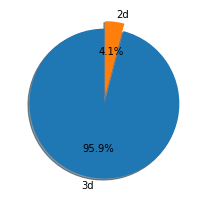

In [7]:
fig, ax = plt.subplots()

counts = data['jarvis_v{}.dimensionality'.format(version)].value_counts()
ax.pie(counts, explode=[0, 0.1], labels=counts.index, autopct='%1.1f%%',
        shadow=True, startangle=90)

fig.set_size_inches(3, 3)
fig.tight_layout()

### How are the spacegroups distributed?
How are the entries distributed throughout the 230 spacegroups?

(1, 231)

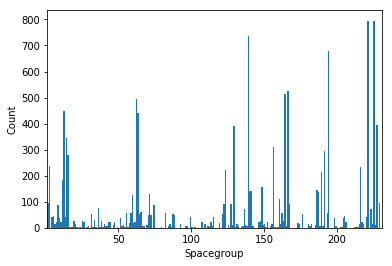

In [8]:
fig, ax = plt.subplots()

ax.hist(data['crystal_structure.space_group_number'], bins=range(1, 231));

ax.set_xlabel('Spacegroup')
ax.set_ylabel('Count')

ax.set_xlim(1, 231)

### Effect of Functionals on Predicted Properties
Jarvis uses two different eXchange-Correlation (XC) functionals for computing band gap energies with DFT: optB88-vdw, and MBJ. These plots show how well they compare

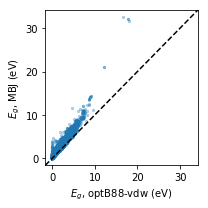

In [9]:
fig, ax = plt.subplots()

# Plot the two values
ax.scatter(data['jarvis_v{}.band_gap.optb88vdw.value'.format(version)], 
           data['jarvis_v{}.band_gap.mbj.value'.format(version)], alpha=0.3, s=5)

# Plot the equality line
ax.set_xlim(min(ax.get_xlim()[0], ax.get_ylim()[0]), max(ax.get_xlim()[1], ax.get_ylim()[1]))
ax.set_ylim(ax.get_xlim())

ax.plot(ax.get_xlim(), ax.get_ylim(), 'k--')

ax.set_xlabel('$E_g$, optB88-vdw (eV)')
ax.set_ylabel('$E_g$, MBJ (eV)')

fig.set_size_inches(3, 3)
fig.tight_layout()

### How related are different elastic moduli?
Are shear and bulk moduli generally correlated?

Text(0,0.5,'Shear Modulus (GPa)')

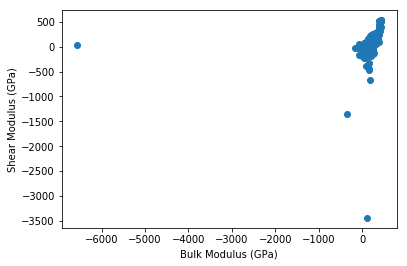

In [10]:
fig, ax = plt.subplots()

subset = data[data['jarvis_v{}.dimensionality'.format(version)] == "3d"]

ax.scatter(subset['jarvis_v{}.elastic_moduli.bulk.value'.format(version)],
                  subset['jarvis_v{}.elastic_moduli.shear.value'.format(version)])

ax.set_xlabel('Bulk Modulus (GPa)')
ax.set_ylabel('Shear Modulus (GPa)')

Same plot, minus the compounds with negative moduli

Text(0,0.5,'Shear Modulus (GPa)')

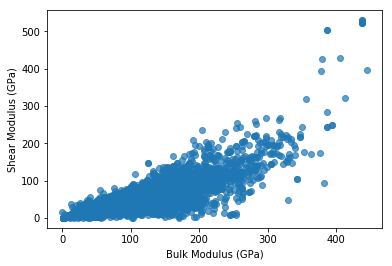

In [11]:
fig, ax = plt.subplots()

subset = subset[np.logical_and(subset['jarvis_v{}.elastic_moduli.bulk.value'.format(version)] > 0,
                subset['jarvis_v{}.elastic_moduli.shear.value'.format(version)] > 0)]

ax.scatter(subset['jarvis_v{}.elastic_moduli.bulk.value'.format(version)],
                  subset['jarvis_v{}.elastic_moduli.shear.value'.format(version)],
          alpha=0.7)

ax.set_xlabel('Bulk Modulus (GPa)')
ax.set_ylabel('Shear Modulus (GPa)')

## Some Example Screening
Just do demonstrate some screening that you can do with the [Forge client](https://github.com/materials-data-facility/forge), which can access via the MDFDataRetrieval object to get access to the raw data

In [12]:
screened_results = mdf.forge.aggregate('mdf.source_name:jarvis_v{0} AND jarvis_v{0}.band_gap.mbj.value:[1.1 TO 1.6] '
                                       'AND jarvis_v{0}.dimensionality:2d'.format(version))

Each record is a dictionary

In [13]:
screened_results[0]

{'crystal_structure': {'number_of_atoms': 7,
  'space_group_number': 164,
  'volume': 542.6510033280861},
 'dft': {'converged': True, 'cutoff_energy': 500},
 'files': [{'data_type': 'ASCII text, with very long lines, with no line terminators',
   'filename': 'JVASP-28130.json',
   'globus': 'globus://e38ee745-6d04-11e5-ba46-22000b92c6ec/MDF/mdf_connect/prod/data/jarvis_v2/jdft_2da/JVASP-28130.json',
   'length': 5040,
   'mime_type': 'text/plain',
   'sha512': 'eeeb2ae77cdc0ea2d1f79ff32aa76fcc8d9d571838152b74b5fcdb2560f3b60ec0a743b29e326530e3e67c5acbe138eec0ef26d2298e659ad70dc9877a845297',
   'url': 'https://e38ee745-6d04-11e5-ba46-22000b92c6ec.e.globus.org/MDF/mdf_connect/prod/data/jarvis_v2/jdft_2da/JVASP-28130.json'}],
 'jarvis_v2': {'band_gap': {'mbj': {'units': 'eV', 'value': 1.2676},
   'optb88vdw': {'units': 'eV', 'value': 1.0772000000000002}},
  'crossreference': {'materials_project': 'mp-676250'},
  'dimensionality': '2d',
  'id': 'JVASP-28130',
  'landing_page': 'https://www.

Print out some materials with band gap energies in the range desired for solar cells

In [14]:
print('Found {} materials with band gaps between 1.1 and 1.6 eV:'.format(len(screened_results)))
for result in screened_results:
    print('Composition: %s - Gap: %.2f eV - URL: %s'%(result['material']['composition'],
                                                      result['jarvis_v{}'.format(version)]['band_gap'].get('mbj', {}).get('value', np.nan),
                                                      result['jarvis_v{}'.format(version)]['landing_page']))

Found 4 materials with band gaps between 1.1 and 1.6 eV:
Composition: Bi2Te4Pb - Gap: 1.27 eV - URL: https://www.ctcms.nist.gov/~knc6/jsmol/JVASP-28130.html
Composition: ThTe3 - Gap: 1.49 eV - URL: https://www.ctcms.nist.gov/~knc6/jsmol/JVASP-27859.html
Composition: Bi2PbSe4 - Gap: 1.14 eV - URL: https://www.ctcms.nist.gov/~knc6/jsmol/JVASP-28127.html
Composition: Nb(SeBr)2 - Gap: 1.22 eV - URL: https://www.ctcms.nist.gov/~knc6/jsmol/JVASP-14420.html
